In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import urllib
from datetime import datetime, timedelta
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn import linear_model

In [2]:
# import firm
d1 = pd.read_excel('11beta.xlsx')
d1.dropna(inplace=True)
d1.sort_values(['GVKey','DataDate'], inplace=True)


# 31 to 1
d1['DataDate']=d1['DataDate']-pd.offsets.MonthBegin(1)


# %
d1['x1'] = d1.groupby('GVKey')['MkVal'].pct_change()
d1.dropna(inplace=True)


# clean
d5 = d1.loc[:, ['GVKey','DataDate','x1']]
d5 = d5.rename(columns={'DataDate': 'Data'})
d5 = d5[d5['x1']<0.4]
d5 = d5[d5['x1']>-0.4]


# dohodnosti rinka 
y= pd.read_csv('yahoo.csv',sep=',')
y['Close1'] = y['Close'].shift(+1)
y['x']=(y['Close']-y['Close1'])/y['Close1']
y.dropna(inplace=True)
y1 = y[['Date','x']]
y1 = y1.rename(columns={'Date': 'Data'})
y1['Data']= pd.DatetimeIndex(y1['Data'])


# merge market + firm
dd = d5.merge(y1)

# reg 10
z10 = ('1990-1-1','1991-1-1','1992-1-1','1993-1-1','1994-1-1',
       '1995-1-1','1996-1-1','1997-1-1','1998-1-1',
       '1999-1-1','2000-1-1','2001-1-1','2002-1-1',
       '2003-1-1','2004-1-1','2005-1-1','2006-1-1',
       '2007-1-1','2008-1-1','2009-1-1','2010-1-1',
       '2011-1-1','2012-1-1','2013-1-1','2014-1-1',
       '2015-1-1','2016-1-1','2017-1-1','2018-1-1',)

# reg10 int 10
res10 = pd.DataFrame({'GVKey': [1],
                    'Beta': [1],
                    'Year':[1]},
                    index=[0])
for i in range(19):
    g = (dd[(dd['Data'] >= z10[i]) & (dd['Data'] <= z10[i+10])]
             .groupby(['GVKey'])[['x1','x']]
             .apply(lambda x: OLS.from_formula('x1 ~ x', x)
                                 .fit()
                                 .params['x'])
             .reset_index(name='Beta'))
    g['Year'] = 2000 + i
    res10 = res10.append(g)
res10.rename(columns= {'GVKey': 'FIRM'}, inplace=True)    

# reg 5
z5 = ('1995-1-1','1996-1-1','1997-1-1','1998-1-1','1999-1-1',
      '2000-1-1','2001-1-1','2002-1-1','2003-1-1',
      '2004-1-1','2005-1-1','2006-1-1','2007-1-1',
      '2008-1-1','2009-1-1','2010-1-1','2011-1-1',
      '2012-1-1','2013-1-1','2014-1-1','2015-1-1',
      '2016-1-1','2017-1-1','2018-1-1')

# reg 5 int 5
res5 = pd.DataFrame({'GVKey': [1],
                    'Beta': [1],
                    'Year':[1]},
                    index=[0])
for i in range(19):
    g = (dd[(dd['Data'] >= z5[i]) & (dd['Data'] <= z5[i+5])]
             .groupby(['GVKey'])[['x1','x']]
             .apply(lambda x: OLS.from_formula('x1 ~ x', x)
                                 .fit()
                                 .params['x'])
             .reset_index(name='Beta'))
    g['Year'] = 2000 + i
    res5 = res5.append(g)  
res5.rename(columns= {'GVKey': 'FIRM'}, inplace=True)

# rename
res10 = res10[['FIRM', 'Year', 'Beta']]
res10 = res10.rename(columns = {'Beta': 'Beta10'})
res5 = res5[['FIRM', 'Year', 'Beta']]
res5 = res5.rename(columns = {'Beta': 'Beta5'})

# itog beta
merge_beta = res5.merge(res10)
merge_beta = merge_beta.sort_values(['Year'])
merge_beta = merge_beta.drop(axis=0, index = 0)
merge_beta['beta'] = (merge_beta['Beta5'] + merge_beta['Beta10'])/2
merge_beta = merge_beta[(merge_beta['beta']<2.5) &(merge_beta['beta']>-0.5)]
merge_beta['beta'].describe()

count    14574.000000
mean         0.983919
std          0.506762
min         -0.490992
25%          0.616894
50%          0.951546
75%          1.310807
max          2.499918
Name: beta, dtype: float64

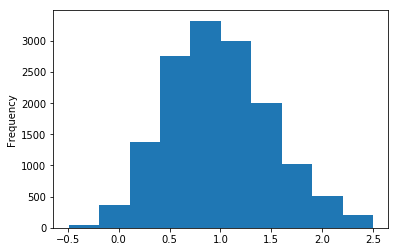

In [3]:
merge_beta['beta'].plot(style='r--', kind='hist')

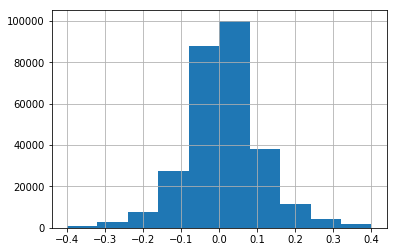

In [4]:
# dohodnosti kompaniy
d5.x1.hist()

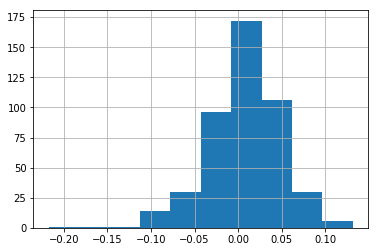

In [5]:
# dohodnosti rinka
y1.x.hist()

In [6]:
# Подтягиваем табличку с премией рынка и безрисковыми доходностями
damodaran = pd.read_excel('http://www.stern.nyu.edu/~adamodar/pc/datasets/histimpl.xls', 
                          sheet_name = 'Historical Impl Premiums', header = 5)
year = np.arange(1961, 2019, 1)
list = np.arange(1,59,1)
rf = damodaran.loc[list, ['T.Bond Rate']]
ERP = damodaran.loc[list, ['Implied Premium (FCFE)']]
help = pd.DataFrame(np.column_stack([rf, ERP, year]), 
                               columns=['Rf', 'ERP', 'Year'])
help_1 = help[['Year','ERP', 'Rf' ]]
Re = merge_beta.merge(help_1)
Re['Re'] = Re['Rf'] + Re['ERP'] * Re['beta']
R1 = Re.sort_values(['FIRM', 'Year'])
R1.reset_index(inplace=True)
R1.drop('index', axis=1, inplace=True)
R1 = R1.assign(Year=lambda d: d.pop('Year').astype('int'))
R1['Re'].describe()

count    14574.000000
mean         0.081927
std          0.024639
min         -0.007442
25%          0.064569
50%          0.079721
75%          0.097147
max          0.180741
Name: Re, dtype: float64

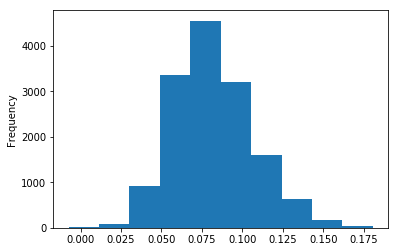

In [7]:
# raspredelenie Re sobstvenniy capital
R1['Re'].plot(style='r--', kind='hist')

In [8]:
xu = pd.read_excel('RRR.xlsx')
xu.dropna(inplace=True)
xu = xu.rename(columns = {'ICR': 'RATING'})
xu.dropna(inplace=True)
xu.head()
bins = [-1000000, 0.1999,0.6499,0.7999,1.2499,1.4999,1.7499,1.9999,2.2499,2.4999,2.9999,4.2499,5.4999,6.4999,8.4999,10000000]
labels = ['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15']
xu['FORMULA'] = pd.cut(xu['RATING'], bins=bins, labels=labels, right=True)
formulas = """
F15=0.006
F14=0.008
F13=0.01
F12=0.011
F11=0.0125
F10=0.016
F9=0.025
F8=0.03
F7=0.0375
F6=0.045
F5=0.055
F4=0.065
F3=0.08
F2=0.105
F1=0.14
  
"""
x = xu.eval(formulas).dropna(subset=['FORMULA'])
x['RES'] = x.lookup(x.index, x['FORMULA'])
xu.loc[xu['RATING'].notna(), 'RES'] = x['RES']
spread = xu[['DataDate','GVKey','RES']]
spread = spread.rename(columns = {'RES': 'spread','DataDate': "Year",'GVKey':'FIRM' })
spread['Year'] = pd.DatetimeIndex(spread['Year']).year
spread.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12491 entries, 0 to 13748
Data columns (total 3 columns):
Year      12491 non-null int64
FIRM      12491 non-null int64
spread    12379 non-null float64
dtypes: float64(1), int64(2)
memory usage: 390.3 KB


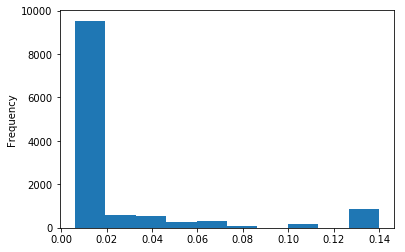

In [9]:
# Spreads
spread['spread'].plot(style='r--', kind='hist')

In [10]:
# merge Re and Spread
WACC = R1.merge(spread)
WACC['Rd'] = WACC['Rf'] + WACC['spread']
WACC.describe()

,FIRM,Beta5,Beta10,beta,ERP,Rf,Re,Year,spread,Rd
count,11911.000000,11911.000000,11911.000000,11911.000000,11911.000000,11911.000000,11911.000000,11911.000000,11805.000000,11805.000000
mean,33306.597851,1.003633,0.969722,0.986678,0.048752,0.033205,0.082206,2009.045588,0.023820,0.057020
std,49424.351877,0.552983,0.486388,0.500368,0.009585,0.010471,0.024428,5.187260,0.036193,0.038452
min,1013.000000,-1.566773,-0.490992,-0.490992,0.028700,0.017600,-0.007349,2000.000000,0.006000,0.023600
25%,5680.000000,0.600461,0.613563,0.616686,0.041000,0.022700,0.064456,2005.000000,0.006000,0.032800
50%,10581.000000,0.972147,0.938022,0.957186,0.049600,0.032900,0.079964,2009.000000,0.008000,0.046400
75%,29127.000000,1.361412,1.290327,1.311659,0.057800,0.042200,0.097475,2013.000000,0.016000,0.057900
max,316056.000000,3.227329,2.702592,2.499918,0.064300,0.051100,0.180741,2018.000000,0.140000,0.191100


In [11]:
# Считаем Доли долга и Доли собственного капитала
path = "https://drive.google.com/uc?export=download&id=10YUDn6hLfXfyZQPIgaiuN12SzHGqznQA" 
fail = urllib.request.urlretrieve(path, "DE.xlsx")
DE = pd.read_excel('DE.xlsx')
D = DE[['Date_1', 'gvkey', 'D']]
D = D.rename(columns = {'Date_1': 'Date'})
E = DE[['Date_2', 'gvkey.1', 'MkVal']]
E = E.rename(columns = {'Date_2': 'Date', 'gvkey.1': 'gvkey'})
DE = D.merge(E)
DE['dD'] = DE['D']/ (DE['MkVal'] + DE['D'])
DE['dE'] = DE['MkVal']/ (DE['MkVal'] + DE['D'])
DE = DE.rename(columns = {'Date': 'Year', 'gvkey': 'FIRM'})
DE = DE.assign(Year=DE.Year.dt.year)
DE.drop_duplicates(inplace=True)
DE.dropna(inplace=True)
DE.describe()

,Year,FIRM,D,MkVal,dD,dE
count,12334.000000,12334.000000,1.233400e+04,12334.000000,12334.000000,12334.000000
mean,2008.905546,34408.583428,8.968674e+03,20699.500434,0.222119,0.777881
std,5.217082,50244.423056,7.982860e+04,44252.092511,0.197587,0.197587
min,2000.000000,1013.000000,0.000000e+00,9.480393,0.000000,0.000439
25%,2004.000000,5786.000000,4.604500e+02,3557.970002,0.069963,0.667036
50%,2009.000000,10894.000000,1.700000e+03,8060.185815,0.170019,0.829981
75%,2013.000000,29649.000000,5.075250e+03,17953.933140,0.332964,0.930037
max,2018.000000,316056.000000,3.296298e+06,882331.517200,0.999561,1.000000


In [12]:
tax = pd.read_excel('tax.xlsx')
tax.dropna(inplace=True)
tax.drop_duplicates(inplace=True)
tax['Year'] = pd.DatetimeIndex(tax['Year']).year
tax = tax[(tax['tax']<1)]
tax['tax'] = np.where(tax['tax'] >= 0, tax['tax'], 0)
DE = DE.merge(tax)
DE.describe()

,Year,FIRM,D,MkVal,dD,dE,EBIT,txt,tax
count,9878.000000,9878.000000,9.878000e+03,9878.000000,9878.000000,9878.000000,9878.000000,9878.000000,9878.000000
mean,2008.708038,38323.130492,5.547744e+03,12599.655897,0.225514,0.774486,2411.667775,175.237163,0.174082
std,5.209978,52211.224726,5.746589e+04,24119.557694,0.201176,0.201176,6357.785557,912.260569,0.237607
min,2000.000000,1013.000000,0.000000e+00,9.480393,0.000000,0.000439,-80053.000000,-45415.000000,0.000000
25%,2004.000000,6669.000000,3.649055e+02,2992.681541,0.067032,0.659742,368.137250,15.520500,0.000406
50%,2008.000000,12206.000000,1.285111e+03,6388.171750,0.174690,0.825310,861.400500,97.201000,0.063649
75%,2013.000000,31887.000000,3.872822e+03,12969.968091,0.340258,0.932968,2078.500000,239.692500,0.257129
max,2018.000000,316056.000000,3.160074e+06,732187.632150,0.999561,1.000000,130622.000000,24263.000000,0.999708


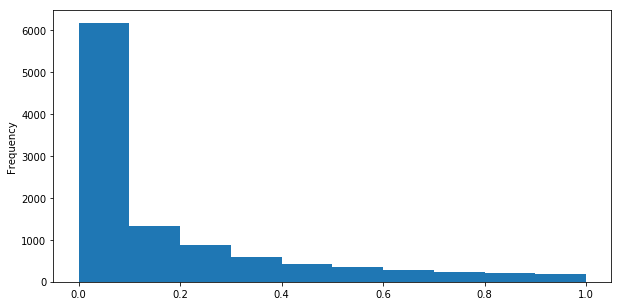

In [13]:
tax['tax'].plot(style='r--', figsize = (10,5), kind = 'hist')

In [14]:
# WACC 
ITOG = DE.merge(WACC)
ITOG['WACC'] = ITOG['dD'] * ITOG['Rd']*(1-ITOG['tax'])  + ITOG['dE'] * ITOG['Re']
WACC = ITOG.loc[:, ['Year', 'FIRM', 'WACC', 'D']]
WACC.describe()

,Year,FIRM,WACC,D
count,9198.000000,9198.000000,9114.000000,9.198000e+03
mean,2008.847032,37206.075669,0.078325,5.818966e+03
std,5.195344,51619.625275,0.025355,5.951564e+04
min,2000.000000,1013.000000,0.004392,0.000000e+00
25%,2004.000000,6481.750000,0.060492,4.407250e+02
50%,2009.000000,11636.000000,0.074407,1.409508e+03
75%,2013.000000,30990.000000,0.091879,4.046750e+03
max,2018.000000,316056.000000,0.186160,3.160074e+06


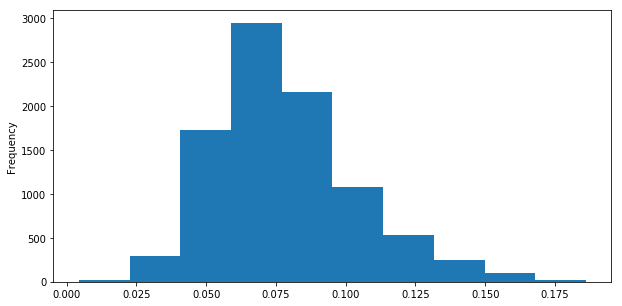

In [15]:
WACC['WACC'].plot(style='r--', figsize = (10,5), kind = 'hist')

In [16]:
# FCFF
df4 = pd.read_excel('Fundamental_Data.xlsx')
FC = df4.loc[:,['DataDate','GVKey Код компании','capx (Capital Expenditures) капитальные расходы','oancf (Operating Activities - Net Cash Flow) CF операционная деятельность - чистый денежный поток']]
FC.dropna(inplace=True)
FC['FCF']=FC['oancf (Operating Activities - Net Cash Flow) CF операционная деятельность - чистый денежный поток']-FC['capx (Capital Expenditures) капитальные расходы']
FC = FC.rename(columns={'GVKey Код компании': 'FIRM', 'DataDate':'Year'})
FC['Mount']=FC['Year']
FC['Year'] = pd.DatetimeIndex(FC['Year']).year
FC = FC.assign(Year=lambda d: d.pop('Year').astype('int'))
FC = FC.rename(columns={'FCF':'FCFF'})
FCFF = FC.loc[:,['Year','FIRM','FCFF','Mount']]
FCFF.describe()

,Year,FIRM,FCFF
count,13077.000000,13077.000000,13077.000000
mean,2009.067753,35366.001988,1091.793458
std,5.195931,50917.939298,4909.629028
min,2000.000000,1013.000000,-110560.000000
25%,2005.000000,5959.000000,86.709000
50%,2009.000000,11115.000000,351.296000
75%,2014.000000,29830.000000,949.000000
max,2018.000000,316056.000000,127491.000000


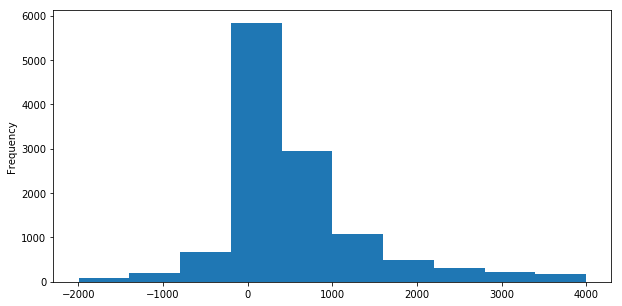

In [17]:
FCFF = FCFF[(FCFF['FCFF']<4000)&(FCFF['FCFF']> -2000)]
FCFF['FCFF'].plot(style='r--', figsize = (10,5), kind = 'hist')

In [18]:
#G_firm
g_firm = pd.read_excel('sales.xlsx')
g_firm["Sales_3"] = g_firm['Sales'].shift(+3)
g_firm['g_firm'] = (g_firm['Sales'] - g_firm['Sales_3'])/g_firm['Sales_3']
g_firm['g_firm'] = g_firm['g_firm']/3
g_firm = g_firm[(g_firm['Year']>'2002-12-31')]
g_firm['Year'] = pd.DatetimeIndex(g_firm['Year']).year
g_firm = g_firm[(g_firm['g_firm']<0.5)&(g_firm['g_firm']> -0.5)]
g_firm.describe()

,Year,FIRM,Sales,Sales_3,g_firm
count,10883.000000,10883.000000,10883.000000,10883.000000,10883.000000
mean,2010.285215,35080.426169,14538.140724,13920.583906,0.057163
std,4.564097,51083.755557,30991.865819,29420.624038,0.141907
min,2003.000000,1013.000000,-1408.000000,-4234.472000,-0.380322
25%,2006.000000,5860.000000,2369.528500,2200.922500,-0.015854
50%,2010.000000,10974.000000,5516.461000,5260.956000,0.048234
75%,2014.000000,29751.000000,13144.706500,12780.351500,0.127076
max,2018.000000,316056.000000,496785.000000,483521.000000,0.498634


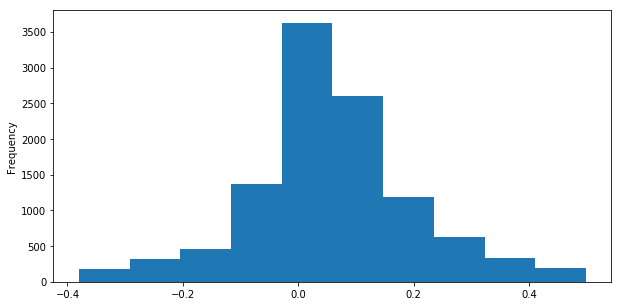

In [19]:
g_firm['g_firm'].plot(style='r--', figsize = (10,5), kind = 'hist')

In [20]:
g_firm['g_sec'] = g_firm.groupby(["Sector", 'Year'])["g_firm"].transform("mean")
g_firm.describe()

,Year,FIRM,Sales,Sales_3,g_firm,g_sec
count,10883.000000,10883.000000,10883.000000,10883.000000,10883.000000,10841.000000
mean,2010.285215,35080.426169,14538.140724,13920.583906,0.057163,0.057776
std,4.564097,51083.755557,30991.865819,29420.624038,0.141907,0.060341
min,2003.000000,1013.000000,-1408.000000,-4234.472000,-0.380322,-0.166198
25%,2006.000000,5860.000000,2369.528500,2200.922500,-0.015854,0.028233
50%,2010.000000,10974.000000,5516.461000,5260.956000,0.048234,0.058187
75%,2014.000000,29751.000000,13144.706500,12780.351500,0.127076,0.095942
max,2018.000000,316056.000000,496785.000000,483521.000000,0.498634,0.255078


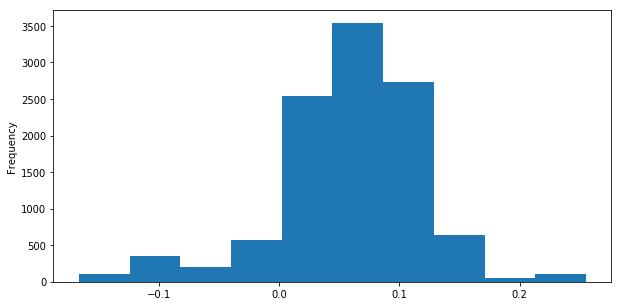

In [21]:
g_firm['g_sec'].plot(style='r--', figsize = (10,5), kind = 'hist')

In [22]:
WACC.describe()

,Year,FIRM,WACC,D
count,9198.000000,9198.000000,9114.000000,9.198000e+03
mean,2008.847032,37206.075669,0.078325,5.818966e+03
std,5.195344,51619.625275,0.025355,5.951564e+04
min,2000.000000,1013.000000,0.004392,0.000000e+00
25%,2004.000000,6481.750000,0.060492,4.407250e+02
50%,2009.000000,11636.000000,0.074407,1.409508e+03
75%,2013.000000,30990.000000,0.091879,4.046750e+03
max,2018.000000,316056.000000,0.186160,3.160074e+06


In [23]:
# merge tables
res = g_firm.merge(WACC)
res = res.merge(FCFF)
res = res.drop_duplicates()
res = res.sort_values(['FIRM', 'Year'])
res.reset_index(inplace=True)
res = res[['Year', 'Sector','FIRM','g_sec', 'g_firm', 'WACC', 'FCFF', 'Mount']]
res = res[res['FCFF']>0]
res.describe()

,Year,FIRM,g_sec,g_firm,WACC,FCFF
count,6102.000000,6102.000000,6088.000000,6102.000000,6047.000000,6102.000000
mean,2010.163061,39433.698623,0.058048,0.063748,0.076981,619.272834
std,4.548465,53342.207550,0.057498,0.139205,0.023227,671.796270
min,2003.000000,1013.000000,-0.166198,-0.380322,0.004392,0.864000
25%,2006.000000,6653.000000,0.028233,-0.009401,0.060597,186.597250
50%,2010.000000,12441.000000,0.059558,0.054770,0.074027,395.000000
75%,2014.000000,61409.000000,0.095942,0.133009,0.090033,776.300000
max,2018.000000,316056.000000,0.255078,0.498634,0.176588,3995.000000


In [24]:
ROCE = pd.read_excel('ROCE.xlsx')
ROCE['Year'] = pd.DatetimeIndex(ROCE['Year']).year
res = res.merge(ROCE)
res = res.drop(['EBIT', 'E', 'LD'], axis= 1)
res.dropna(inplace=True)
res.drop_duplicates(inplace=True)
res.describe()

,Year,FIRM,g_sec,g_firm,WACC,FCFF,ROCE
count,6065.000000,6065.000000,6065.000000,6065.000000,6065.000000,6065.000000,6065.000000
mean,2010.125474,39349.069909,0.057758,0.063341,0.077027,624.515619,0.947927
std,4.547672,53029.098474,0.057699,0.137930,0.023128,673.746116,4.877061
min,2003.000000,1013.000000,-0.166198,-0.380322,0.004392,0.864000,-139.591133
25%,2006.000000,6653.000000,0.028233,-0.009614,0.060797,187.688000,0.069739
50%,2010.000000,12441.000000,0.059558,0.054300,0.074093,400.400000,0.208841
75%,2014.000000,61483.000000,0.095942,0.131513,0.089961,785.363000,0.606205
max,2018.000000,316056.000000,0.255078,0.498634,0.176588,3995.000000,141.539135


In [25]:
res['av_g'] = res.groupby('Year')["g_firm"].transform("mean")
res['av_ROCE'] = res.groupby('Year')["ROCE"].transform("mean")

In [26]:
conditions = [
    (res['g_firm'] >= res['av_g']) & (res['ROCE'] >= res['av_ROCE']),
    (res['g_firm'] >= res['av_g']) & (res['ROCE'] <= res['av_ROCE']),
    (res['g_firm'] <= res['av_g']) & (res['ROCE'] >= res['av_ROCE']),
    (res['g_firm'] <= res['av_g']) & (res['ROCE'] <= res['av_ROCE'])]
choices = [1, 3, 2, 4]

In [27]:
# rabotaeeeeett vaahhahaha
res['cvadrant'] = np.select(conditions, choices, default=0)
res.describe()

,Year,FIRM,g_sec,g_firm,WACC,FCFF,ROCE,av_g,av_ROCE,cvadrant
count,6065.000000,6065.000000,6065.000000,6065.000000,6065.000000,6065.000000,6065.000000,6065.000000,6065.000000,6065.000000
mean,2010.125474,39349.069909,0.057758,0.063341,0.077027,624.515619,0.947927,0.063341,0.947927,3.180379
std,4.547672,53029.098474,0.057699,0.137930,0.023128,673.746116,4.877061,0.049623,0.305755,0.937410
min,2003.000000,1013.000000,-0.166198,-0.380322,0.004392,0.864000,-139.591133,-0.078914,0.421695,1.000000
25%,2006.000000,6653.000000,0.028233,-0.009614,0.060797,187.688000,0.069739,0.036572,0.704230,3.000000
50%,2010.000000,12441.000000,0.059558,0.054300,0.074093,400.400000,0.208841,0.076736,0.896359,3.000000
75%,2014.000000,61483.000000,0.095942,0.131513,0.089961,785.363000,0.606205,0.092162,1.073048,4.000000
max,2018.000000,316056.000000,0.255078,0.498634,0.176588,3995.000000,141.539135,0.127700,1.580459,4.000000


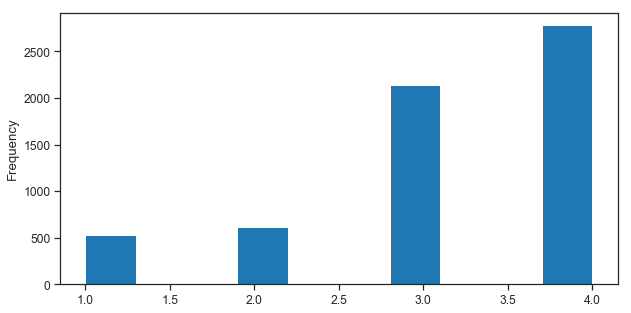

In [52]:
res['cvadrant'].plot(style='r--', figsize = (10,5), kind = 'hist')

In [53]:
# 1-st segment. TOP firms
df1 = res[res['cvadrant'] == 1]

df1['DIF'] = df1['WACC'] - df1['g_sec']
df1= df1[df1['DIF']>= 0.04]

df1['dif'] = (df1['g_sec'] - df1['g_firm'])/3
df1['g1'] = (df1['g_firm'] + df1['dif']) 
df1['g2'] = (df1['g1'] + df1['dif'])
df1['g3'] = (df1['g2'] + df1['dif'])

df1['FCFF1'] = df1['FCFF'] * (1+df1['g_firm'])
df1['FCFF2'] = df1['FCFF1'] * (1+df1['g_firm'])
df1['FCFF3'] = df1['FCFF2'] * (1+df1['g_firm'])

df1['FCFF4'] = df1['FCFF3'] * (1+df1['g1'])
df1['FCFF5'] = df1['FCFF4'] * (1+df1['g2'])
df1['FCFF6'] = df1['FCFF5'] * (1+df1['g3'])

df1['FCFF7'] = df1['FCFF6'] * (1 + df1['g_sec'])

a = df1['FCFF1']/(1+df1['WACC'])**1
b = df1['FCFF2']/(1+df1['WACC'])**2
c = df1['FCFF3']/(1+df1['WACC'])**3
d = df1['FCFF4']/(1+df1['WACC'])**4
e = df1['FCFF5']/(1+df1['WACC'])**5
f = df1['FCFF6']/(1+df1['WACC'])**6

df1['cur'] =  a + b + c + d + e + f

df1['terminal'] = (df1['FCFF7']/ df1['DIF'])/(1+df1['WACC'])**7

df1['ev'] = df1['terminal'] + df1['cur']

df1 = df1[df1['ev']<= 40000]
df1 = df1[['Year','Mount', 'FIRM', 'FCFF','ev', 'cvadrant']] 

df1.describe()


C:\Users\1200596\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Year,FIRM,FCFF,ev,cvadrant
count,123.000000,123.000000,123.000000,123.000000,123.0
mean,2010.536585,60611.926829,320.708789,7051.570242,1.0
std,5.161796,67794.066045,321.775504,7339.151431,0.0
min,2003.000000,1230.000000,1.724000,16.650651,1.0
25%,2008.000000,11260.000000,129.568500,1848.463306,1.0
50%,2010.000000,28118.000000,240.247000,4305.210804,1.0
75%,2016.000000,114746.500000,401.725500,9257.607728,1.0
max,2018.000000,316056.000000,1904.000000,37454.535154,1.0


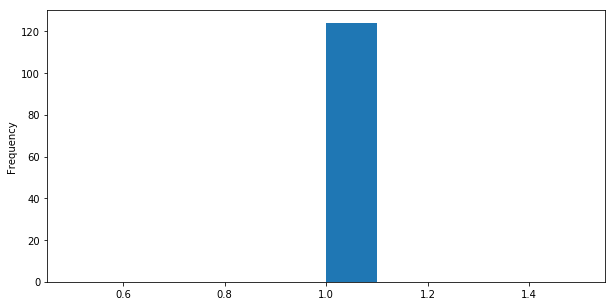

In [29]:
df1['cvadrant'].plot(style='r--', figsize = (10,5), kind = 'hist')

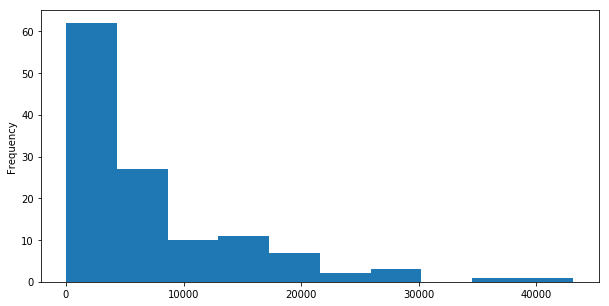

In [30]:
df1['ev'].plot(style='r--', figsize = (10,5), kind = 'hist')

In [54]:
# 2-d segment. focus
df2 = res[res['cvadrant'] == 2]

df2['DIF'] = df2['WACC'] - df2['g_sec']
df2= df2[df2['DIF']>= 0.04]
df2['ev'] = (df2['FCFF']*(1+df2['g_firm']))/(df2['WACC']-df2['g_sec'])
df2= df2[df2['ev']<= 40000]
df2 = df2[['Year','Mount', 'FIRM', 'FCFF', 'ev', 'cvadrant']] 

df2.describe()

C:\Users\1200596\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Year,FIRM,FCFF,ev,cvadrant
count,229.000000,229.000000,229.000000,229.000000,229.0
mean,2010.388646,42734.655022,299.550074,4318.774187,2.0
std,5.275901,54915.435896,392.796821,6449.453369,0.0
min,2003.000000,1013.000000,1.206000,17.994181,2.0
25%,2004.000000,7409.000000,78.891000,679.187027,2.0
50%,2010.000000,14535.000000,178.300000,1916.251832,2.0
75%,2016.000000,63501.000000,329.026000,4754.995166,2.0
max,2018.000000,294524.000000,3363.000000,36707.947551,2.0


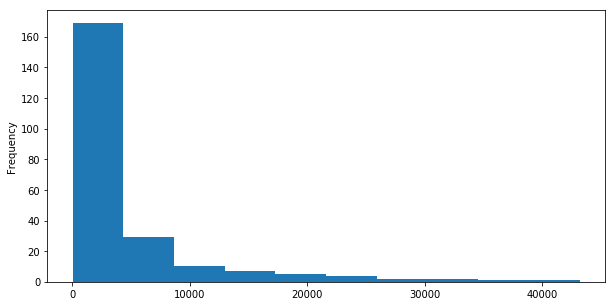

In [32]:
df2['ev'].plot(style='r--', figsize = (10,5), kind = 'hist')

In [55]:
# 3-d segment. agressive firms
df3 = res[res['cvadrant'] == 3]

df3['DIF'] = df3['WACC'] - df3['g_sec']
df3= df3[df3['DIF']>= 0.04]

df3['dif'] = (df3['g_sec'] - df3['g_firm'])/3
df3['g1'] = (df3['g_firm'] + df3['dif']) 
df3['g2'] = (df3['g1'] + df3['dif'])
df3['g3'] = (df3['g2'] + df3['dif'])

df3['FCFF1'] = df3['FCFF'] * (1+df3['g_firm'])

df3['FCFF2'] = df3['FCFF1'] * (1+df3['g1'])
df3['FCFF3'] = df3['FCFF2'] * (1+df3['g2'])
df3['FCFF4'] = df3['FCFF3'] * (1+df3['g3'])

df3['FCFF5'] = df3['FCFF4'] * (1 + df3['g_sec'])

a = df3['FCFF1']/(1+df3['WACC'])**1
b = df3['FCFF2']/(1+df3['WACC'])**2
c = df3['FCFF3']/(1+df3['WACC'])**3
d = df3['FCFF4']/(1+df3['WACC'])**4

df3['cur'] =  a + b + c + d

df3['terminal'] = (df3['FCFF5']/ df3['DIF'])/(1+df3['WACC'])**5

df3['ev'] = df3['terminal'] + df3['cur']

df3 = df3[df3['ev']<= 40000]
df3 = df3[['Year','Mount', 'FIRM', 'FCFF', 'ev', 'cvadrant']] 

df3.describe()

C:\Users\1200596\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Year,FIRM,FCFF,ev,cvadrant
count,543.000000,543.000000,543.000000,543.000000,543.0
mean,2009.534070,48185.788214,590.140133,9749.215258,3.0
std,5.075286,57644.910922,494.422986,8277.891586,0.0
min,2003.000000,1209.000000,9.000000,42.649276,3.0
25%,2003.000000,8045.000000,215.690500,3277.272202,3.0
50%,2010.000000,15521.000000,436.000000,7036.647674,3.0
75%,2013.000000,65609.000000,884.000000,15326.752159,3.0
max,2018.000000,260774.000000,3233.000000,39758.562285,3.0


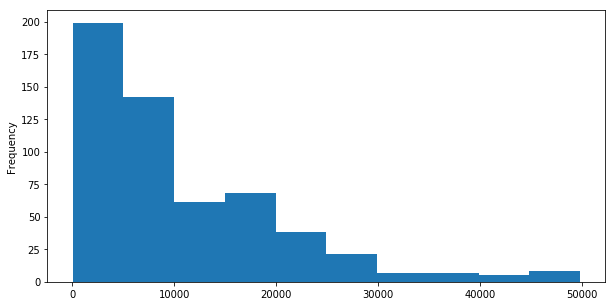

In [34]:
df3['ev'].plot(style='r--', figsize = (10,5), kind = 'hist')

In [56]:
# 4-th segment. badly
df4 = res[res['cvadrant'] == 4]
df4['DIF'] = df4['WACC'] - df4['g_sec']
df4= df4[df4['DIF']>= 0.04]

df4['dif'] = (df4['g_sec'] - df4['g_firm'])/5
df4['g1'] = (df4['g_firm'] + df4['dif']) 
df4['g2'] = (df4['g1'] + df4['dif'])
df4['g3'] = (df4['g2'] + df4['dif'])
df4['g4'] = (df4['g3'] + df4['dif'])
df4['g5'] = (df4['g4'] + df4['dif'])

df4['FCFF1'] = df4['FCFF'] * (1+df4['g1'])
df4['FCFF2'] = df4['FCFF1'] * (1+df4['g2'])
df4['FCFF3'] = df4['FCFF2'] * (1+df4['g3'])
df4['FCFF4'] = df4['FCFF3'] * (1+df4['g4'])
df4['FCFF5'] = df4['FCFF4'] * (1+df4['g5'])
df4['FCFF6'] = df4['FCFF5'] * (1 + df4['g_sec'])

a = df4['FCFF1']/(1+df4['WACC'])**1
b = df4['FCFF2']/(1+df4['WACC'])**2
c = df4['FCFF3']/(1+df4['WACC'])**3
d = df4['FCFF4']/(1+df4['WACC'])**4
e = df4['FCFF5']/(1+df4['WACC'])**5


df4['cur'] =  a + b + c + d + e

df4['terminal'] = (df4['FCFF6']/ df4['DIF'])/(1+df4['WACC'])**6

df4['ev'] = df4['terminal'] + df4['cur']

df4 = df4[df4['ev']<= 40000]
df4 = df4[['Year','Mount', 'FIRM', 'FCFF','ev', 'cvadrant']] 

df4.describe()

C:\Users\1200596\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Year,FIRM,FCFF,ev,cvadrant
count,1022.000000,1022.000000,1022.000000,1022.000000,1022.0
mean,2010.589041,30584.239726,576.307796,6988.485720,4.0
std,4.898919,48899.071601,610.666577,7717.414989,0.0
min,2003.000000,1013.000000,1.130000,2.990951,4.0
25%,2006.000000,5783.000000,166.330500,1501.248408,4.0
50%,2011.000000,10190.000000,376.644000,4078.220934,4.0
75%,2015.000000,27780.000000,761.250000,10053.762187,4.0
max,2018.000000,316056.000000,3910.000000,39028.739182,4.0


In [36]:
DE = pd.read_excel('DE.xlsx')
D = DE[['Date_1', 'gvkey', 'D']]
D = D.rename(columns = {'Date_1': 'Year', 'gvkey': 'FIRM'})
D = D.assign(Year=D.Year.dt.year)



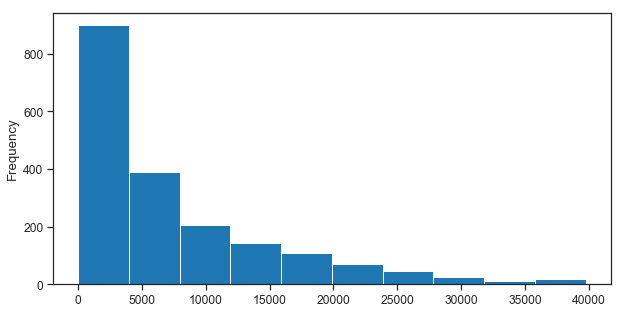

In [61]:
ev = df1.append(df2)
ev = ev.append(df3)
ev = ev.append(df4)
ev['ev'].plot(style='r--', figsize = (10,5), kind = 'hist')

In [38]:
# yld market add
dd = pd.read_excel('MkVal.xlsx')
dd = dd[dd['MK'] < 50000]

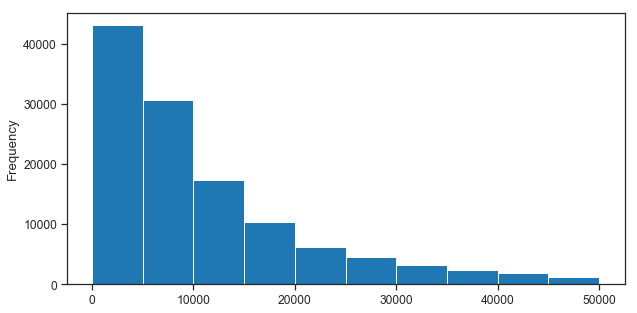

In [62]:
dd['Doxod'] = dd.groupby('FIRM')['MK'].pct_change()
dd['Doxod3'] = dd.groupby('FIRM')['MK'].pct_change(periods=3)
dd['Doxod12'] = dd.groupby('FIRM')['MK'].pct_change(periods=12)

dd['dox1'] = dd['Doxod'].shift(-1)
dd['dox4'] = dd['Doxod3'].shift(-3)
dd['dox12'] = dd['Doxod12'].shift(-12)

dd['dox1']=dd['dox1']*100
dd['dox4']=dd['dox4']*100
dd['dox12']=dd['dox12']*100

dd = dd[dd['dox1']<25]
dd= dd[dd['dox1']>-25]
dd=dd[dd['dox12']<100]
dd=dd[dd['dox4']<45]
dd=dd[dd['dox4']>-27]

ev = ev.merge(dd)

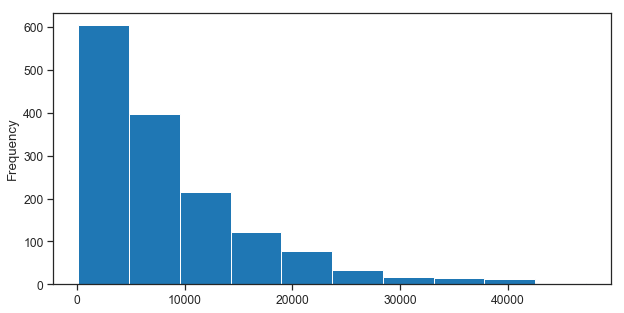

In [63]:
ev['MK'].plot(style='r--', figsize = (10,5), kind = 'hist')

In [40]:
ev = ev.merge(D)
ev.drop_duplicates(inplace=True)
ev.dropna(inplace=True)
ev['nev'] = ev['ev'] - ev['D']
ev = ev[ev['nev'] > 0]

C:\Users\1200596\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,10.256,'MK')

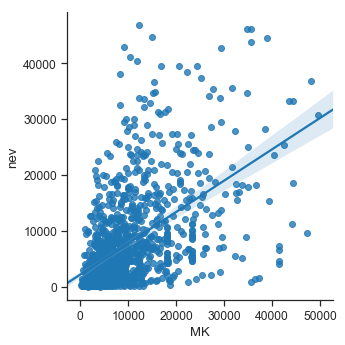

In [41]:
##################################################




ev['nedo']= ((ev['nev'] - ev['MK'])/ev['MK'])*100

ev = ev.loc[:,['Mount','FIRM','MK','nev','nedo','dox1','dox4','dox12', 'cvadrant', 'Year']]
ev.drop_duplicates(inplace=True)
ev.dropna(inplace=True)

ev = ev[ev['Year']<2018]

sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
sns.lmplot('MK','nev', data=ev)
plt.ylabel('nev')
plt.xlabel('MK')

In [42]:
ev.describe()

,FIRM,MK,nev,nedo,dox1,dox4,dox12,cvadrant,Year
count,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000
mean,42075.341520,8880.437614,7117.242271,-7.154827,2.952574,5.518283,15.785448,3.264006,2010.219493
std,57470.023245,8070.133261,8194.063536,95.191554,7.342891,12.999584,33.601643,0.895106,4.486644
min,1075.000000,252.516000,2.366717,-99.860416,-24.615385,-25.031180,-99.192231,1.000000,2003.000000
25%,6565.000000,3323.829750,1511.523524,-65.794592,-1.709975,-3.280545,-3.494799,3.000000,2008.000000
50%,12338.000000,6211.193300,4221.165510,-33.972585,2.771215,5.249827,16.116231,4.000000,2011.000000
75%,61676.000000,11776.606290,9192.077073,17.260908,7.706255,13.717561,37.344673,4.000000,2014.000000
max,316056.000000,49532.547000,46771.859693,854.188943,24.992526,44.927279,99.025811,4.000000,2017.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021D8D6BEA58>,
      dtype=object)

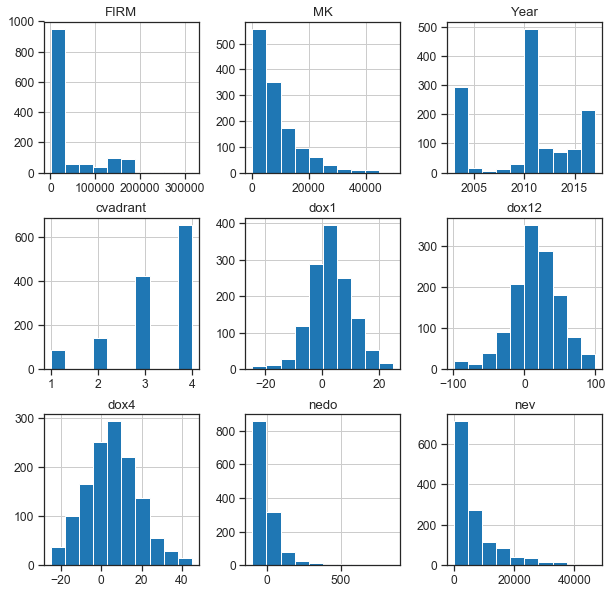

In [43]:
ev.hist(figsize=(10,10))

In [44]:
z = ev[(ev['nedo']< 62.771869)]
z = z[z['nedo']>-70.099094]
z.describe()

,FIRM,MK,nev,nedo,dox1,dox4,dox12,cvadrant,Year
count,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000
mean,44221.992638,9135.113713,7133.529524,-19.821423,3.090776,5.156048,14.589216,3.214724,2010.734969
std,59448.033774,8243.080797,7214.337496,34.418099,7.137249,12.817150,34.355410,0.902783,4.415846
min,1075.000000,252.516000,173.421721,-69.983369,-24.232028,-25.031180,-98.358277,1.000000,2003.000000
25%,6547.000000,3479.317660,2514.071931,-48.509364,-1.564711,-3.620666,-4.906628,3.000000,2010.000000
50%,12389.000000,6481.218240,4628.165510,-26.951716,2.767776,5.249827,14.904372,3.000000,2011.000000
75%,63080.000000,12026.463330,9002.518645,4.384250,8.037784,13.592291,35.445690,4.000000,2015.000000
max,316056.000000,49532.547000,46115.459321,62.436746,24.992526,44.927279,99.025811,4.000000,2017.000000


C:\Users\1200596\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,10.256,'MK')

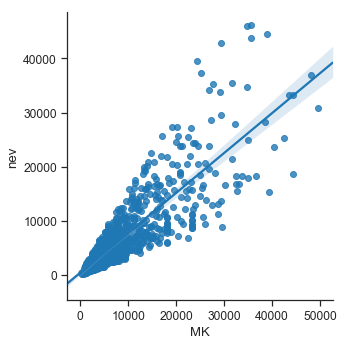

In [45]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
sns.lmplot('MK','nev', data=z)
plt.ylabel('nev')
plt.xlabel('MK')

C:\Users\1200596\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,10.256,'nedo')

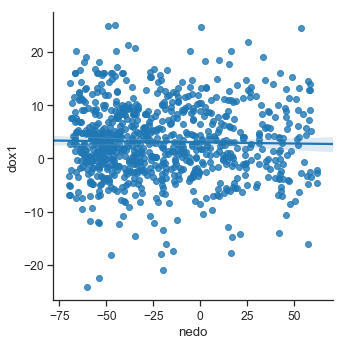

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn import linear_model
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
sns.lmplot('nedo','dox1', data=z)
plt.ylabel('dox1')
plt.xlabel('nedo')

C:\Users\1200596\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,10.256,'nedo')

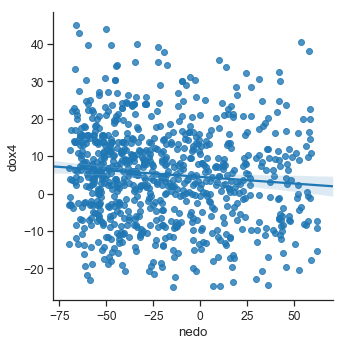

In [47]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
sns.lmplot('nedo','dox4', data=z)
plt.ylabel('dox4')
plt.xlabel('nedo')

C:\Users\1200596\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,10.256,'nedo')

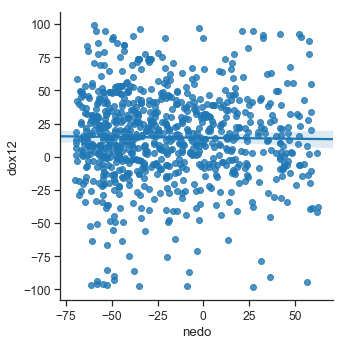

In [48]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
sns.lmplot('nedo','dox12', data=z)
plt.ylabel('dox12')
plt.xlabel('nedo')

In [80]:
ev.corr()

,FIRM,MK,nev,nedo,dox1,dox4,dox12,cvadrant,Year
FIRM,1.000000,0.149908,0.137001,0.011871,0.109055,0.025222,0.000114,-0.148284,0.094068
MK,0.149908,1.000000,0.553120,-0.146924,-0.028360,-0.075094,-0.195744,0.095044,0.197979
nev,0.137001,0.553120,1.000000,0.498720,-0.008249,-0.102962,-0.146055,-0.005048,0.229843
nedo,0.011871,-0.146924,0.498720,1.000000,0.043047,-0.057268,-0.016947,-0.084146,0.088988
dox1,0.109055,-0.028360,-0.008249,0.043047,1.000000,0.394058,0.218616,-0.033598,0.058686
dox4,0.025222,-0.075094,-0.102962,-0.057268,0.394058,1.000000,0.405915,-0.041689,-0.233060
dox12,0.000114,-0.195744,-0.146055,-0.016947,0.218616,0.405915,1.000000,-0.052621,-0.291288
cvadrant,-0.148284,0.095044,-0.005048,-0.084146,-0.033598,-0.041689,-0.052621,1.000000,0.032606
Year,0.094068,0.197979,0.229843,0.088988,0.058686,-0.233060,-0.291288,0.032606,1.000000
